In [56]:
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pyntcloud import PyntCloud
from pyntcloud import scalar_fields
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors.kde import KernelDensity
from sklearn.neighbors.kde import KDTree
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import pickle

#import pclpy
# install this pip sudo apt install libgl1-mesa-glx
import open3d as o3d

import json
import pdal
import time

In [2]:
cloud = PyntCloud.from_file('volume/shared/data/Werk2_classified_part1.ply')
cloud

PyntCloud
2044148 points with 2 scalar fields
0 faces in mesh
0 kdtrees
0 voxelgrids
Centroid: 535279.0, 5279006.5, 455.98358154296875
Other attributes:

In [3]:
cloud.points.head()

,x,y,z,scalar_PointSourceId,scalar_Classification
0,535030.1875,5278938.0,455.441010,1.0,7.0
1,535027.6250,5278937.0,455.625000,1.0,7.0
2,535027.5000,5278937.0,455.622986,1.0,7.0
3,535027.0625,5278937.0,455.660004,1.0,7.0
4,535026.7500,5278935.5,455.773987,1.0,7.0


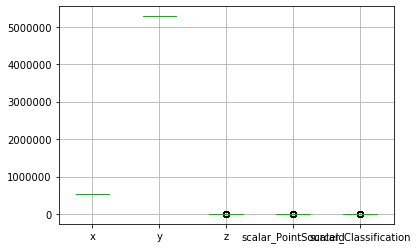

In [4]:
cloud.points.boxplot()

# create feature from the original method

In [5]:
##Cacluate 50 neighbours for determining the geometrical features of each point
neigh = cloud.get_neighbors(k=50)
neigh.shape

(2044148, 50)

In [6]:
#The commented features are not used because the computation is a little high for these features and only the 
#geometrical features are used
'''
#kde=KernelDensity(kernel='gaussian',bandwidth=0.2).fit(cloud3.points[['x','y','z']])
#density=kde.score_samples(cloud3.points[['x','y','z']])
#cloud3.points.add(density,axis=1)

#vox=cloud3.add_structure("voxelgrid")
#vox_x=cloud3.add_scalar_field("voxel_x",voxelgrid_id=vox)
#vox_y=cloud3.add_scalar_field("voxel_y",voxelgrid_id=vox)
#vox_n=cloud3.add_scalar_field("voxel_n",voxelgrid_id=vox)
#vox_z=cloud3.add_scalar_field("voxel_z",voxelgrid_id=vox)
#inc=cloud.add_scalar_field("inclination_degrees")
#ori=cloud.add_scalar_field("orientation_degrees")
'''
eig=cloud.add_scalar_field("eigen_values",k_neighbors=neigh)
ani=cloud.add_scalar_field("anisotropy",ev=eig)
cur=cloud.add_scalar_field("curvature",ev=eig)
eigent=cloud.add_scalar_field("eigenentropy",ev=eig)
su=cloud.add_scalar_field("eigen_sum",ev=eig)
lin=cloud.add_scalar_field("linearity",ev=eig)
om=cloud.add_scalar_field("omnivariance",ev=eig)
pla=cloud.add_scalar_field("planarity",ev=eig)
sph=cloud.add_scalar_field("sphericity",ev=eig)

/opt/anaconda/envs/pyntcloud/lib/python3.7/site-packages/pyntcloud/scalar_fields/eigenvalues.py:50: RuntimeWarning: divide by zero encountered in log
  result += ev[:, i] * np.log(ev[:, i])
/opt/anaconda/envs/pyntcloud/lib/python3.7/site-packages/pyntcloud/scalar_fields/eigenvalues.py:50: RuntimeWarning: invalid value encountered in multiply
  result += ev[:, i] * np.log(ev[:, i])


In [191]:
cloud.points.head()

,x,y,z,scalar_PointSourceId,scalar_Classification,e1(51),e2(51),e3(51),anisotropy(51),curvature(51),eigenentropy(51),eigen_sum(51),linearity(51),omnivariance(51),planarity(51),sphericity(51)
0,535030.1875,5278938.0,455.441010,1.0,7.0,4.034260,0.058808,0.032204,0.992017,0.007806,-5.349805,4.125272,0.985423,0.196957,0.006595,0.007983
1,535027.6250,5278937.0,455.625000,1.0,7.0,9.009204,0.067166,0.060978,0.993232,0.006673,-19.452496,9.137347,0.992545,0.332916,0.000687,0.006768
2,535027.5000,5278937.0,455.622986,1.0,7.0,9.027584,0.070006,0.057108,0.993674,0.006238,-19.513607,9.154697,0.992245,0.330472,0.001429,0.006326
3,535027.0625,5278937.0,455.660004,1.0,7.0,9.509903,0.077140,0.052684,0.994460,0.005465,-21.066758,9.639728,0.991888,0.338100,0.002572,0.005540
4,535026.7500,5278935.5,455.773987,1.0,7.0,12.252534,0.043350,0.032153,0.997376,0.002608,-30.455006,12.328037,0.996462,0.257521,0.000914,0.002624


In [192]:
X = cloud.points.drop(columns=['x', 'y', 'z', 'scalar_PointSourceId', 'scalar_Classification'])
X.head()

,e1(51),e2(51),e3(51),anisotropy(51),curvature(51),eigenentropy(51),eigen_sum(51),linearity(51),omnivariance(51),planarity(51),sphericity(51)
0,4.034260,0.058808,0.032204,0.992017,0.007806,-5.349805,4.125272,0.985423,0.196957,0.006595,0.007983
1,9.009204,0.067166,0.060978,0.993232,0.006673,-19.452496,9.137347,0.992545,0.332916,0.000687,0.006768
2,9.027584,0.070006,0.057108,0.993674,0.006238,-19.513607,9.154697,0.992245,0.330472,0.001429,0.006326
3,9.509903,0.077140,0.052684,0.994460,0.005465,-21.066758,9.639728,0.991888,0.338100,0.002572,0.005540
4,12.252534,0.043350,0.032153,0.997376,0.002608,-30.455006,12.328037,0.996462,0.257521,0.000914,0.002624


In [193]:
y = (cloud.points["scalar_Classification"].values).astype(np.uint8)

In [194]:
### split into train and test
from sklearn.model_selection import train_test_split

In [195]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

# randomforest

In [196]:
tree = RandomForestClassifier()

In [197]:
timestamp = time.time()

tree.fit(X_train, y_train)

print(time.time() - timestamp)

/opt/anaconda/envs/pyntcloud/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


135.9414620399475


In [201]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
#     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    fig, ax = plt.subplots(figsize = (8, 8))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

Normalized confusion matrix
predict score is: 0.790922877479637


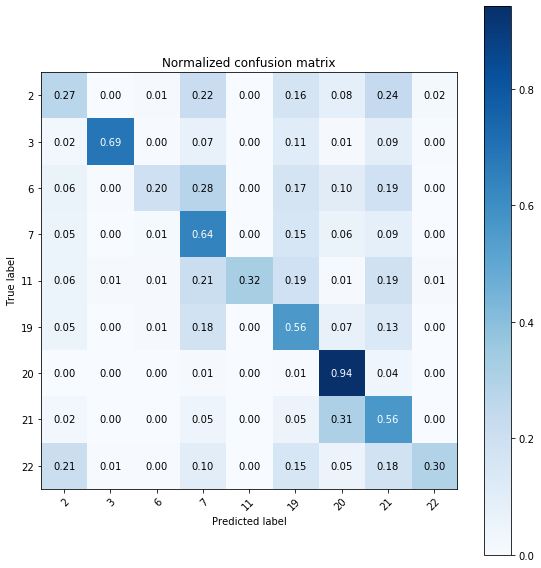

In [204]:
y_pred = tree.predict(X_test)

plot_confusion_matrix(y_test, y_pred, classes=['2', '3', '6', '7', '11', '19', '20', '21', '22'], normalize=True,
                      title='Normalized confusion matrix')

print('predict score is: {}'.format(tree.score(X_test, y_test)))
plt.show()

# create new feature based on 2D

In [167]:
cloud.points.tail()

,x,y,z,scalar_PointSourceId,scalar_Classification,e1(51),e2(51),e3(51),anisotropy(51),curvature(51),eigenentropy(51),eigen_sum(51),linearity(51),omnivariance(51),planarity(51),sphericity(51)
2044143,535288.0000,5279015.5,457.424011,9.0,22.0,9.495397,0.694426,0.180917,0.980947,0.017445,-20.809752,10.370740,0.926867,1.060570,0.054080,0.019053
2044144,535288.0000,5279016.0,457.428986,9.0,22.0,6.364278,0.554728,0.127470,0.979971,0.018090,-11.188915,7.046476,0.912837,0.766324,0.067134,0.020029
2044145,535288.2500,5279017.0,457.458008,9.0,22.0,9.572022,0.443939,0.086169,0.990998,0.008530,-21.049964,10.102131,0.953621,0.715418,0.037377,0.009002
2044146,535287.3125,5279016.0,457.580994,9.0,22.0,6.339722,0.643836,0.204057,0.967813,0.028390,-11.100612,7.187615,0.898444,0.940876,0.069369,0.032187
2044147,535286.4375,5279015.5,457.601013,9.0,22.0,9.649570,0.677795,0.130314,0.986495,0.012461,-21.345584,10.457679,0.929759,0.948124,0.056736,0.013505


In [168]:
cloud.points['y']

0          5278938.0
1          5278937.0
2          5278937.0
3          5278937.0
4          5278935.5
5          5278936.5
6          5278935.5
7          5278936.5
8          5278936.5
9          5278935.5
10         5278936.5
11         5278935.5
12         5278936.5
13         5278935.5
14         5278936.5
15         5278935.5
16         5278936.5
17         5278935.5
18         5278935.5
19         5278935.5
20         5278935.5
21         5278935.5
22         5278935.5
23         5278935.5
24         5278935.5
25         5278935.5
26         5278935.0
27         5278935.0
28         5278935.0
29         5278935.0
             ...    
2044118    5279012.0
2044119    5279012.0
2044120    5279012.0
2044121    5279012.0
2044122    5279012.0
2044123    5279012.0
2044124    5279012.0
2044125    5279012.0
2044126    5279012.0
2044127    5279012.0
2044128    5279012.0
2044129    5279011.5
2044130    5279012.0
2044131    5279011.0
2044132    5279011.5
2044133    5279011.5
2044134    52

In [76]:
xx = cloud.points[['x', 'y']].values
xx

array([[ 535030.2 , 5278938.  ],
       [ 535027.6 , 5278937.  ],
       [ 535027.5 , 5278937.  ],
       ...,
       [ 535288.25, 5279017.  ],
       [ 535287.3 , 5279016.  ],
       [ 535286.44, 5279015.5 ]], dtype=float32)

In [78]:
tree = KDTree(xx)

In [93]:
point_15cm = tree.query_radius(xx[:], r=0.15)

In [125]:
density = []
for point in point_15cm:
    density.append(len(point))
density

[71,
 67,
 67,
 55,
 36,
 36,
 38,
 59,
 60,
 37,
 66,
 38,
 64,
 37,
 62,
 39,
 63,
 38,
 38,
 44,
 44,
 40,
 39,
 41,
 42,
 41,
 32,
 37,
 38,
 41,
 43,
 94,
 88,
 81,
 41,
 48,
 81,
 90,
 100,
 95,
 47,
 69,
 90,
 39,
 39,
 70,
 36,
 51,
 45,
 31,
 80,
 83,
 84,
 62,
 36,
 52,
 13,
 50,
 52,
 48,
 48,
 48,
 46,
 46,
 46,
 48,
 91,
 91,
 98,
 98,
 68,
 47,
 44,
 50,
 38,
 35,
 26,
 37,
 41,
 40,
 69,
 39,
 42,
 29,
 34,
 34,
 36,
 39,
 40,
 40,
 41,
 43,
 45,
 63,
 32,
 64,
 83,
 63,
 66,
 36,
 76,
 71,
 33,
 23,
 30,
 39,
 38,
 34,
 32,
 24,
 40,
 40,
 30,
 84,
 63,
 71,
 74,
 77,
 32,
 36,
 32,
 75,
 36,
 33,
 28,
 11,
 74,
 74,
 36,
 74,
 38,
 70,
 16,
 75,
 35,
 39,
 38,
 42,
 37,
 73,
 79,
 27,
 73,
 81,
 79,
 77,
 81,
 47,
 78,
 79,
 75,
 63,
 66,
 84,
 29,
 32,
 32,
 31,
 28,
 19,
 32,
 23,
 24,
 27,
 76,
 32,
 27,
 34,
 32,
 30,
 28,
 24,
 35,
 76,
 75,
 32,
 31,
 28,
 18,
 80,
 79,
 59,
 29,
 27,
 25,
 18,
 18,
 27,
 36,
 81,
 83,
 82,
 80,
 78,
 31,
 20,
 82,
 79,
 27,
 30,

In [150]:
xx[point_15cm[0]]

array([[ 535030.06, 5278938.  ],
       [ 535030.06, 5278938.  ],
       [ 535030.06, 5278938.  ],
       [ 535030.06, 5278938.  ],
       [ 535030.06, 5278938.  ],
       [ 535030.06, 5278938.  ],
       [ 535030.06, 5278938.  ],
       [ 535030.06, 5278938.  ],
       [ 535030.06, 5278938.  ],
       [ 535030.06, 5278938.  ],
       [ 535030.06, 5278938.  ],
       [ 535030.06, 5278938.  ],
       [ 535030.06, 5278938.  ],
       [ 535030.06, 5278938.  ],
       [ 535030.1 , 5278938.  ],
       [ 535030.1 , 5278938.  ],
       [ 535030.1 , 5278938.  ],
       [ 535030.1 , 5278938.  ],
       [ 535030.1 , 5278938.  ],
       [ 535030.1 , 5278938.  ],
       [ 535030.1 , 5278938.  ],
       [ 535030.1 , 5278938.  ],
       [ 535030.1 , 5278938.  ],
       [ 535030.1 , 5278938.  ],
       [ 535030.2 , 5278938.  ],
       [ 535030.2 , 5278938.  ],
       [ 535030.2 , 5278938.  ],
       [ 535030.2 , 5278938.  ],
       [ 535030.2 , 5278938.  ],
       [ 535030.3 , 5278938.  ],
       [ 5

In [166]:
aa = np.append(xx[point_15cm[50000]], [xx[50000]], axis=0)
aa

array([[ 535190.4 , 5278960.5 ],
       [ 535190.4 , 5278960.5 ],
       [ 535190.4 , 5278960.5 ],
       [ 535190.4 , 5278960.5 ],
       [ 535190.4 , 5278960.5 ],
       [ 535190.4 , 5278960.5 ],
       [ 535190.4 , 5278960.5 ],
       [ 535190.4 , 5278960.5 ],
       [ 535190.4 , 5278960.5 ],
       [ 535190.4 , 5278960.5 ],
       [ 535190.4 , 5278960.5 ],
       [ 535190.4 , 5278960.5 ],
       [ 535190.4 , 5278960.5 ],
       [ 535190.4 , 5278960.5 ],
       [ 535190.4 , 5278960.5 ],
       [ 535190.4 , 5278960.5 ],
       [ 535190.44, 5278960.5 ],
       [ 535190.44, 5278960.5 ],
       [ 535190.44, 5278960.5 ],
       [ 535190.44, 5278960.5 ],
       [ 535190.44, 5278960.5 ],
       [ 535190.44, 5278960.5 ],
       [ 535190.44, 5278960.5 ],
       [ 535190.44, 5278960.5 ],
       [ 535190.44, 5278960.5 ],
       [ 535190.44, 5278960.5 ],
       [ 535190.44, 5278960.5 ],
       [ 535190.44, 5278960.5 ],
       [ 535190.44, 5278960.5 ],
       [ 535190.44, 5278960.5 ],
       [ 5

In [164]:
np.cov(aa.T)

array([[0.00795162, 0.        ],
       [0.        , 0.        ]])

In [172]:
np.linalg.eigvals(np.cov(aa.T))[0]

0.007951617324561394

In [101]:
cloud.points.loc[point_15cm[0]]

,x,y,z,scalar_PointSourceId,scalar_Classification,e1(51),e2(51),e3(51),anisotropy(51),curvature(51),eigenentropy(51),eigen_sum(51),linearity(51),omnivariance(51),planarity(51),sphericity(51)
4029,535030.0625,5278938.0,455.462006,1.0,7.0,4.058188,0.052282,0.034237,0.991563,0.008260,-5.414633,4.144707,0.987117,0.193669,0.004446,0.008437
4031,535030.0625,5278938.0,457.075989,1.0,7.0,4.001551,0.053106,0.033459,0.991639,0.008184,-5.279314,4.088116,0.986729,0.192292,0.004910,0.008361
4032,535030.0625,5278938.0,456.678009,1.0,7.0,4.015137,0.058844,0.030267,0.992462,0.007374,-5.308765,4.104248,0.985344,0.192659,0.007117,0.007538
4033,535030.0625,5278938.0,456.247009,1.0,7.0,4.002933,0.052720,0.034789,0.991309,0.008505,-5.280198,4.090442,0.986830,0.194357,0.004479,0.008691
4034,535030.0625,5278938.0,455.592987,1.0,7.0,4.019717,0.051353,0.035994,0.991046,0.008764,-5.320150,4.107064,0.987225,0.195133,0.003821,0.008954
4036,535030.0625,5278938.0,456.958008,1.0,7.0,4.014555,0.051065,0.035385,0.991186,0.008628,-5.309798,4.101005,0.987280,0.193580,0.003906,0.008814
1732213,535030.0625,5278938.0,455.290985,8.0,21.0,4.107124,0.068337,0.027848,0.993220,0.006625,-5.519135,4.203310,0.983361,0.198456,0.009858,0.006781
4037,535030.0625,5278938.0,456.549988,1.0,7.0,4.004923,0.052637,0.035570,0.991118,0.008690,-5.283277,4.093131,0.986857,0.195730,0.004262,0.008882
4038,535030.0625,5278938.0,455.882996,1.0,7.0,4.002934,0.048852,0.035761,0.991066,0.008749,-5.285580,4.087548,0.987796,0.191231,0.003270,0.008934
4035,535030.0625,5278938.0,457.351990,1.0,7.0,4.016433,0.046439,0.037962,0.990548,0.009257,-5.317694,4.100835,0.988438,0.192026,0.002111,0.009452


In [209]:
def add_2d_feature(cloud_2d, r):
    """
    input: ndarray with two dimension, radius for searching neighbors
    output: density within the given radius for each points, two eigenvalue of all the neigbors
    """
    ### build tree 
    kdtree = KDTree(cloud_2d)  
    
    ### find query of neighbor for each point in the cloud
    neighbors_query = kdtree.query_radius(cloud_2d, r=r)   
    
    ### count how many neighbors within the given radius for each point, compute their two eigenvalue
    density = []
    e1 = []
    e2 = []
    
    for i, neighbors in enumerate(neighbors_query):
        density.append(len(neighbors)) ### density
        
        pointCloud_local = np.append(cloud_2d[neighbors], [cloud_2d[i]], axis=0)
        eigenvalues = np.linalg.eigvals(np.cov(pointCloud_local.T))
        e1.append(eigenvalues[0])
        e2.append(eigenvalues[1])
            
    return density, e1, e2

In [178]:
density_2d, e1_2d, e2_2d = add_2d_feature(cloud.points[['x', 'y']].values, r=0.15)

In [205]:
X2 = cloud.points.drop(columns=['x', 'y', 'z', 'scalar_PointSourceId', 'scalar_Classification'])
X2['density_2d'] = density_2d
X2['e1_2d'] = e1_2d
X2['e2_2d'] = e2_2d
X2.head()

,e1(51),e2(51),e3(51),anisotropy(51),curvature(51),eigenentropy(51),eigen_sum(51),linearity(51),omnivariance(51),planarity(51),sphericity(51),density_2d,e1_2d,e2_2d
0,4.034260,0.058808,0.032204,0.992017,0.007806,-5.349805,4.125272,0.985423,0.196957,0.006595,0.007983,71,0.007702,0.0
1,9.009204,0.067166,0.060978,0.993232,0.006673,-19.452496,9.137347,0.992545,0.332916,0.000687,0.006768,67,0.007432,0.0
2,9.027584,0.070006,0.057108,0.993674,0.006238,-19.513607,9.154697,0.992245,0.330472,0.001429,0.006326,67,0.007616,0.0
3,9.509903,0.077140,0.052684,0.994460,0.005465,-21.066758,9.639728,0.991888,0.338100,0.002572,0.005540,55,0.006218,0.0
4,12.252534,0.043350,0.032153,0.997376,0.002608,-30.455006,12.328037,0.996462,0.257521,0.000914,0.002624,36,0.007801,0.0


In [206]:
y2 = (cloud.points["scalar_Classification"].values).astype(np.uint8)

In [207]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=1, stratify=y)

In [208]:
timestamp = time.time()

tree.fit(X2_train, y2_train)

print(time.time() - timestamp)

117.16983795166016


Normalized confusion matrix
predict score is: 0.8432991708044909


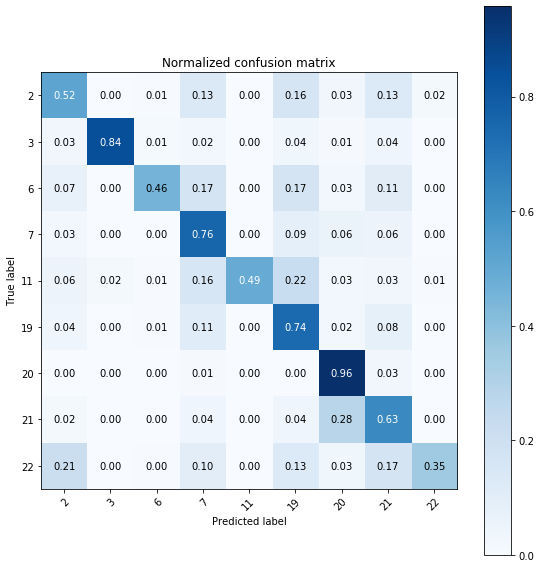

In [210]:
y2_pred = tree.predict(X2_test)

plot_confusion_matrix(y2_test, y2_pred, classes=['2', '3', '6', '7', '11', '19', '20', '21', '22'], normalize=True,
                      title='Normalized confusion matrix')

print('predict score is: {}'.format(tree.score(X2_test, y2_test)))
plt.show()